In [1]:
from pydantic import BaseModel, ConfigDict, Field
import numpy as np
from itertools import product
from random import choices
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from scipy.spatial.distance import pdist, squareform
from scipy.sparse.csgraph import connected_components
import plotly.graph_objects as go
from typing import Literal
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter
import os

In [2]:
INIT_VEL = np.zeros(2, dtype=np.float32)
MAX_SPEED: np.float32 = np.float32(5)
MAX_FORCE: np.float32 = np.float32(2)

## Boids implementation

In [3]:
class Boid(BaseModel):
    model_config = ConfigDict(arbitrary_types_allowed=True)
    position: np.ndarray
    velocity: np.ndarray

class Swarm:
    def __init__(self, n: int, x_max: int, y_max: int) -> list[Boid]:
        xs, ys = np.meshgrid(np.arange(x_max, dtype=np.float32), np.arange(y_max, dtype=np.float32))
        pairs = np.column_stack((xs.ravel(), ys.ravel()))
        idxs = np.random.choice(x_max * y_max, size=n, replace=False)
        self._swarm =  [Boid(position=pairs[i], velocity=INIT_VEL) for i in idxs]
        self.x_limits = (0.0, x_max)
        self.y_limits = (0.0, y_max)

    @staticmethod
    def in_radius(x: Boid, y: Boid, r: float):
        return np.sqrt(np.sum((x.position-y.position)**2)) <= r


    def _get_neighbours(self, target: Boid, radius: float) -> list[Boid]:
        neighbours: list[Boid] = []
        for boid in self._swarm:
            if Swarm.in_radius(target, boid, radius) and boid is not target:
                neighbours.append(boid)
        return neighbours
    

    def update_pos(self, rules: "Rules",  max_speed=MAX_SPEED):
        self._update_vel(rules, max_speed)
        for boid in self._swarm:
            boid.position += boid.velocity
            if boid.position[0] < self.x_limits[0] or boid.position[0] > self.x_limits[1]:
                boid.velocity[0] *= -1
                boid.position[0] = np.clip(boid.position[0], *self.x_limits)
            if boid.position[1] < self.y_limits[0] or boid.position[1] > self.y_limits[1]:
                boid.velocity[1] *= -1
                boid.position[1] = np.clip(boid.position[1], *self.y_limits)
        
    def _update_vel(self, rules: "Rules", max_speed=MAX_SPEED):
        for boid, acc in zip(self._swarm, self.get_acc(rules)):
            boid.velocity += acc
            speed = np.linalg.norm(boid.velocity)
            if speed > max_speed:
                boid.velocity = boid.velocity / speed * max_speed

    def get_acc(self, rules) -> list[np.ndarray]:
        accs = []
        for boid in self._swarm:
            sep = self._compute_sepataion(boid, rules.rs, rules.ws)
            ali = self._compute_allignment(boid, rules.ra, rules.wa)
            coh = self._compute_coheison(boid, rules.rc, rules.wc)
            acc = sep + ali + coh
            accs.append(acc)
        return accs
    
    def _compute_sepataion(self, target: Boid, rs: float, ws: float) -> np.float32:
        neighbours = self._get_neighbours(target, rs)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_pos = np.array([b.position for b in neighbours])
        direction_away = target.position - neighbours_pos
        dist = np.linalg.norm(direction_away, axis=1)
        sep = direction_away / dist[:, None]
        return np.sum(sep, axis=0) * ws

    def _compute_allignment(self, target: Boid, ra: float, wa: float) -> np.float32:
        neighbours = self._get_neighbours(target, ra)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_vel = np.array([b.velocity for b in neighbours])
        avg_vel = np.mean(neighbours_vel, axis=0)
        return (avg_vel - target.velocity) * wa

    def _compute_coheison(self, target: Boid, rc: float, wc: float) -> np.float32:
        neighbours = self._get_neighbours(target, rc)
        if len(neighbours) == 0:
            return  np.zeros(2, dtype=np.float32)
        neighbours_pos = np.array([b.position for b in neighbours])
        center = np.mean(neighbours_pos, axis=0)
        return (center - target.position) * wc


class Rules(BaseModel):
    rs: float = Field(description="radius for separation")
    ws: float = Field(description="weight for separation")
    ra: float = Field(description="radius for alignment")
    wa: float = Field(description="weight for alignment")
    rc: float = Field(description="radius for cohesion")
    wc: float = Field(description="weight for cohesion")

    

class World:
    def __init__(self, size: int) -> None:
        self._size = size
        self._boids: list[Boid] = []
        self._rules: Rules | None = None

    def set_swarm(self, swarm: list[Boid]) -> None:
        self._boids = swarm

    def set_rules(self, rules: Rules) -> None:
        self._rules = rules

    def step(self):
        accs = self._swarm.update_acc(self._rules)
        self._swarm.update_pos(accs)

    def draw(self):
        xs = [b.position[0] for b in self._boids]
        ys = [b.position[1] for b in self._boids]

        plt.scatter(xs, ys)
        plt.xlim(0, self._size)
        plt.ylim(0, self._size)
        plt.show()

In [4]:
class World:
    def __init__(self, size: float, swarm: Swarm, rules: Rules) -> None:
        self._size = size
        self._swarm = swarm
        self._rules = rules

    def step(self):
        self._swarm.update_pos(self._rules)

    def draw(self):
        xs = [b.position[0] for b in self._swarm._swarm]
        ys = [b.position[1] for b in self._swarm._swarm]
        plt.scatter(xs, ys, color="blue", s=50)
        plt.xlim(0, self._size)
        plt.ylim(0, self._size)
        plt.show()

    def animate(self, frames: int = 200, interval: int = 50, save_path: str | None = None):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(0, self._size)
        ax.set_ylim(0, self._size)
        ax.set_xticks([])
        ax.set_yticks([])

        xs = [b.position[0] for b in self._swarm._swarm]
        ys = [b.position[1] for b in self._swarm._swarm]
        scat = ax.scatter(xs, ys, s=40)

        def update(frame):
            self.step()
            xs = [b.position[0] for b in self._swarm._swarm]
            ys = [b.position[1] for b in self._swarm._swarm]
            scat.set_offsets(list(zip(xs, ys)))
            ax.set_title(f"Boids — frame {frame+1}")
            return scat,

        anim = animation.FuncAnimation(fig, update, frames=frames, interval=interval, blit=True)
        
        if save_path is not None:
            writer = animation.PillowWriter(fps=15)
            anim.save(save_path, writer=writer, dpi=150)
            print(f"Saved animation to {save_path}")
        else:
            plt.show()

In [5]:
# swarm = Swarm(n=10, x_max=10, y_max=10)
# # for b in swarm._swarm:
#     # b.velocity = np.random.rand(2) * 1 - 0.5
# rules = Rules(
#     rs=0.0, ws=0.02,
#     ra=0.0, wa=0.0,
#     rc=5.0, wc=1.000,
# )
# world = World(size=10, swarm=swarm, rules=rules)
# world.animate(frames=300, interval=50, save_path="boids.gif")


In [18]:
dt = 0.1
frames = 240

def limit_vector(v, max_val):
    norm = np.linalg.norm(v)
    if norm > max_val and norm > 0:
        return v / norm * max_val
    return v

class Boids:
    """Optimised version of boids based mainly on numpy."""
    def __init__(
        self,
        boids_no: int,
        board_width: int,
        board_height: int,
        boundary: Literal["toroidal", "reflective"] = "toroidal",
        seed: int | None = None,
        debug: bool = False,
    ) -> None:
        self._seed = seed
        self._boids_no = boids_no
        self.height = board_height
        self.width = board_width
        self._init_boids()
        self._boundary = boundary

        self._rules: Rules | None = None
        self._debug = debug
    
    def _init_boids(self) -> None:
        self.rng = np.random.default_rng(self._seed)
        self.boids_pos = self.rng.random(size=(self._boids_no, 2), dtype=np.float32) * np.array([self.width, self.height])
        boids_angles = self.rng.random(size=self._boids_no) * 2 * np.pi
        self.boids_vel = np.column_stack((
            np.cos(boids_angles),
            np.sin(boids_angles),
        )) * (0.5 + self.rng.random(size=self._boids_no) * 10.0)[:, None]

    def set_rules(self, rules: Rules) -> None:
        self._rules = rules
    
    def step(self, dt: float):
        acc = self.get_acc()

        # If debug mode → total acceleration is in acc[:,0]
        if self._debug:
            applied_acc = acc[:, 0]
        else:
            applied_acc = acc

        self.boids_vel += applied_acc * dt

        speeds = np.linalg.norm(self.boids_vel, axis=1)
        for i in range(len(self.boids_vel)):
            if speeds[i] > MAX_SPEED:
                self.boids_vel[i] = self.boids_vel[i] / speeds[i] * MAX_SPEED
        if self._boundary == "toroidal":
            self._move_toroidal(dt)
        else:
            self._move_reflective(dt)

    def _move_toroidal(self, dt: float):
        self.boids_pos = (self.boids_pos + self.boids_vel * dt) % np.array([self.width, self.height])
    
    def _move_reflective(self, dt: float):
        self.boids_pos = (self.boids_pos + self.boids_vel * dt)
        bounds = np.array([self.width, self.height])
        self.boids_vel = np.where(self.boids_pos < 0, -self.boids_vel, self.boids_vel)
        self.boids_pos = np.where(self.boids_pos < 0, -self.boids_pos, self.boids_pos)
        self.boids_vel = np.where(self.boids_pos > bounds, -self.boids_vel, self.boids_vel)
        self.boids_pos = np.where(self.boids_pos > bounds, 2 * bounds - self.boids_pos, self.boids_pos)



    def get_acc(self) -> np.ndarray:
        N = len(self.boids_pos)

        if self._debug:
            # Shape: (N boids, 4 vectors, 2 dimensions)
            # 4 vectors = total, align, cohesion, separation
            acc = np.zeros((N, 4, 2), dtype=np.float32)
        else:
            acc = np.zeros((N, 2), dtype=np.float32)

        for idx, (p_i, v_i) in enumerate(zip(self.boids_pos, self.boids_vel)):

            diff = self._get_difference(p_i)
            dists = np.linalg.norm(diff, axis=1)

            ali_neighbors = (dists > 0) & (dists < self._rules.ra)
            coh_neighbors = (dists > 0) & (dists < self._rules.rc)
            sep_neighbors = (dists > 0) & (dists < self._rules.rs)

            steer_align = self._get_alignment(v_i, ali_neighbors)
            steer_cohesion = self._get_cohesion(v_i, p_i, diff, coh_neighbors)
            steer_separation = self._get_separation(diff, dists, sep_neighbors)

            acc_wa = self._rules.wa * steer_align
            acc_wc = self._rules.wc * steer_cohesion
            acc_ws = self._rules.ws * steer_separation

            force = acc_wa + acc_wc + acc_ws

            if self._debug:
                acc[idx, 0] = force
                acc[idx, 1] = acc_wa
                acc[idx, 2] = acc_wc
                acc[idx, 3] = acc_ws
            else:
                acc[idx] = force

        return acc

    def _get_difference(self, p_i) -> np.ndarray:
        diff = self.boids_pos - p_i
        if self._boundary == "toroidal":
            diff[:, 0] = (diff[:, 0] + self.width / 2) % self.width - self.width / 2
            diff[:, 1] = (diff[:, 1] + self.height / 2) % self.height - self.height / 2
        return diff

    
    def _get_alignment(self, v_i: np.ndarray, neighbors: np.ndarray) -> np.float32:
        if np.any(neighbors):
            avg_vel = self.boids_vel[neighbors].mean(axis=0)
            steer_align = avg_vel - v_i
            steer_align = limit_vector(steer_align, MAX_FORCE)
        else:
            steer_align = np.zeros(2)
        return steer_align
    
    def _get_cohesion(self, v_i: np.ndarray, p_i: np.ndarray, diff: np.ndarray, neighbors: np.ndarray) -> np.float32:
        if np.any(neighbors):
            center_offset = diff[neighbors].mean(axis=0)
            center = p_i + center_offset
            desired = center - p_i
            steer_cohesion = desired - v_i
            steer_cohesion = limit_vector(steer_cohesion, MAX_FORCE)
        else:
            steer_cohesion = np.zeros(2)
        return steer_cohesion
    
    def _get_separation(self, diff: np.ndarray, dists: np.ndarray, neighbors: np.ndarray) -> np.float32:
        if np.any(neighbors):
            close = diff[neighbors]
            close_d = dists[neighbors][:, None]
            push = -np.sum(close / (close_d**2 + 1e-6), axis=0)
            steer_separation = limit_vector(push, MAX_FORCE)
        else:
            steer_separation = np.zeros(2)
        return steer_separation
    
    def animate(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])

        # Main boid scatter + velocity quiver
        scat = ax.scatter(self.boids_pos[:, 0], self.boids_pos[:, 1], s=40)
        quiv_vel = ax.quiver(
            self.boids_pos[:, 0],
            self.boids_pos[:, 1],
            self.boids_vel[:, 0],
            self.boids_vel[:, 1],
            angles='xy',
            scale_units='xy',
            scale=1.5,
            color="black"
        )

        if self._debug:
            quivs = []
            quivs_configs = [
                {"name": "align", "color": "red"},
                {"name": "cohesion", "color": "green"},
                {"name": "separation", "color": "blue"},
            ]
            for q_conf in quivs_configs:
                quivs.append(
                    ax.quiver(
                    self.boids_pos[:, 0], self.boids_pos[:, 1],
                    np.zeros(len(self.boids_pos)), np.zeros(len(self.boids_pos)),
                    angles='xy', scale_units='xy', scale=1.0, color=q_conf["color"]
                ))
            N = len(self.boids_pos)

            # Prepare radii circles
            sep_circles = [patches.Circle((0,0), radius=self._rules.rs) for _ in range(N)]
            ali_circles = [patches.Circle((0,0), radius=self._rules.ra) for _ in range(N)]
            coh_circles = [patches.Circle((0,0), radius=self._rules.rc) for _ in range(N)]

            coll_ali = PatchCollection(ali_circles, facecolor="none", edgecolor="red", alpha=0.25, linewidth=1)
            coll_coh = PatchCollection(coh_circles, facecolor="none", edgecolor="green", alpha=0.25, linewidth=1)
            coll_sep = PatchCollection(sep_circles, facecolor="none", edgecolor="blue", alpha=0.25, linewidth=1)

            ax.add_collection(coll_sep)
            ax.add_collection(coll_ali)
            ax.add_collection(coll_coh)

        def update(frame):
            acc = self.get_acc()
            self.step(dt)

            scat.set_offsets(self.boids_pos)
            quiv_vel.set_offsets(self.boids_pos)
            quiv_vel.set_UVC(self.boids_vel[:, 0], self.boids_vel[:, 1])

            if self._debug:
                for i, center in enumerate(self.boids_pos):
                    sep_circles[i].center = center
                    ali_circles[i].center = center
                    coh_circles[i].center = center

                coll_sep.set_paths(sep_circles)
                coll_ali.set_paths(ali_circles)
                coll_coh.set_paths(coh_circles)
                
                for idx, quiv in enumerate(quivs):
                    quiv.set_offsets(self.boids_pos)
                    quiv.set_UVC(acc[:, idx+1, 0], acc[:, idx+1, 1])

            ax.set_title(f"Boids — frame {frame+1}/{frames}")
            return scat,

        anim = animation.FuncAnimation(
            fig,
            update,
            frames=frames,
            interval=1000/30,
            blit=False
        )

        plt.draw()

        outdir = "boids_output"
        os.makedirs(outdir, exist_ok=True)

        mp4_path = os.path.join(outdir, "boids.mp4")
        anim.save(mp4_path, fps=30, dpi=80)
        

        plt.close(fig)
        

In [19]:
boids = Boids(
    boids_no=60,
    board_width=30,
    board_height=30,
    debug=True,
    seed=10,
)
rules = Rules(
    rs=0.01, ws=1.0,
    ra=5.0, wa=1.0,
    rc=0.2, wc=1.0,
)
boids.set_rules(rules)
boids.animate()

In [20]:
boids = Boids(
    boids_no=60,
    board_width=30,
    board_height=30,
    debug=True,
    seed=10,
    boundary="reflective",
)
rules = Rules(
    rs=0.01, ws=1.0,
    ra=5.0, wa=1.0,
    rc=0.2, wc=1.0,
)
boids.set_rules(rules)
boids.animate()

## Task2

In [21]:
boids = Boids(
    boids_no=60,
    board_width=30,
    board_height=30,
    debug=True,
    seed=10,
)
rules = Rules(
    rs=0.01, ws=1.0,
    ra=5.0, wa=1.0,
    rc=0.2, wc=1.0,
)
boids.set_rules(rules)
boids.step(dt=0.1)


In [22]:
class Boids_v2(Boids):
    """Boids class that collect additional parameters."""
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self._mean_pairwise_distance: np.ndarray | None = None
        self._mean_vel: np.ndarray | None = None
    
    @property
    def mean_vel(self) -> np.ndarray:
        return self._mean_vel

    @property
    def mean_pairwise_distance(self) -> np.ndarray:
        return self._mean_pairwise_distance

    def run_simulation(self, T: int, dt: float) -> None:
        steps = int(np.ceil(T / dt))
        self._mean_pairwise_distance = np.zeros(steps, dtype=np.float32)
        self._mean_vel = np.zeros(steps, dtype=np.float32)
        for i in range(steps):
            self.step(dt)
            speeds = np.linalg.norm(self.boids_vel, axis=1)
            self._mean_vel[i] = np.mean(speeds)
            self._mean_pairwise_distance[i] = pdist(self.boids_pos, "euclidean").mean()
    
    def reset(self) -> None:
        self._init_boids()
    

In [11]:
def task2():
    was = np.linspace(0, 2, 10)
    wcs = np.linspace(0, 2, 10)
    wss = np.linspace(0, 2, 10)
    A, C, S = np.meshgrid(was, wcs, wss, indexing="ij")
    boids = Boids_v2(
        boids_no=60,
        board_width=30,
        board_height=30,
        debug=False,
        seed=44,
    )
    a = A.ravel()
    c = C.ravel()
    s = S.ravel()
    mean_vel = np.zeros_like(a)
    mean_dist = np.zeros_like(a)
    for i in tqdm(range(len(a))):
        rules = Rules(
            rs=1.0, ws=a[i],
            ra=1.0, wa=c[i],
            rc=1.0, wc=s[i],
        )
        boids.reset()
        boids.set_rules(rules)
        boids.run_simulation(T=100, dt=1)
        mean_vel[i] = boids.mean_vel[-1]
        mean_dist[i] = boids.mean_pairwise_distance[-1]
    mean_vel_grid = mean_vel.reshape(A.shape)
    mean_dist_grid = mean_dist.reshape(A.shape)

    fig = go.Figure(data=go.Volume(
        x=A.flatten(),
        y=C.flatten(),
        z=S.flatten(),
        value=mean_vel_grid.flatten(),
        opacity=0.2,
        colorscale='Viridis',
        surface_count=20,
    ))
    fig.show()

    fig = go.Figure(data=go.Volume(
        x=A.flatten(),
        y=C.flatten(),
        z=S.flatten(),
        value=mean_dist_grid.flatten(),
        opacity=0.2,
        colorscale='Viridis',
        surface_count=20,
    ))
    fig.show()


In [12]:
task2()

100%|██████████| 1000/1000 [02:19<00:00,  7.14it/s]


## Task 3

In [23]:
class Boids_v3(Boids_v2):
    def get_mean_alignment(self) -> np.float32:
        vel_unit = self.boids_vel / np.linalg.norm(self.boids_vel, axis=1)[:, np.newaxis]
        alignment_vector = np.sum(vel_unit, axis=0)
        return np.linalg.norm(alignment_vector) / len(self.boids_vel)

    def get_gyration(self) -> np.float32:
        center_of_mass = np.mean(self.boids_pos, axis=0)
        squared_distances = np.sum((self.boids_pos - center_of_mass)**2, axis=1)
        return np.sqrt(np.mean(squared_distances))

In [24]:
def task3():
    boids = Boids_v3(
        boids_no=60,
        board_width=30,
        board_height=30,
        seed=10,
    )
    boids_reflective = Boids_v3(
        boids_no=60,
        board_width=30,
        board_height=30,
        seed=10,
        boundary="reflective",
    )
    rules = Rules(
        rs=0.01, ws=1.0,
        ra=5.0, wa=1.0,
        rc=0.2, wc=1.0,
    )
    boids.set_rules(rules)
    boids_reflective.set_rules(rules)
    t = 100
    gyrations = np.zeros((t, 2), dtype=np.float32)
    alignment = np.zeros((t, 2), dtype=np.float32)
    for i in range(t):
        boids.step(1.0)
        gyrations[i, 0] = boids.get_gyration()
        alignment[i, 0] = boids.get_mean_alignment()
        boids_reflective.step(1.0)
        gyrations[i, 1] = boids_reflective.get_gyration()
        alignment[i, 1] = boids_reflective.get_mean_alignment()
    fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    axs[0].plot(gyrations, label=["Toroidal", "Reflective"])
    axs[0].set_title("Gyrations")
    axs[0].set_ylabel("Value")
    axs[0].grid()
    axs[0].legend()

    axs[1].plot(alignment, label=["Toroidal", "Reflective"])
    axs[1].set_title("Alignment")
    axs[1].set_ylabel("Value")
    axs[1].set_xlabel("$t$")
    axs[1].grid()
    axs[1].legend()

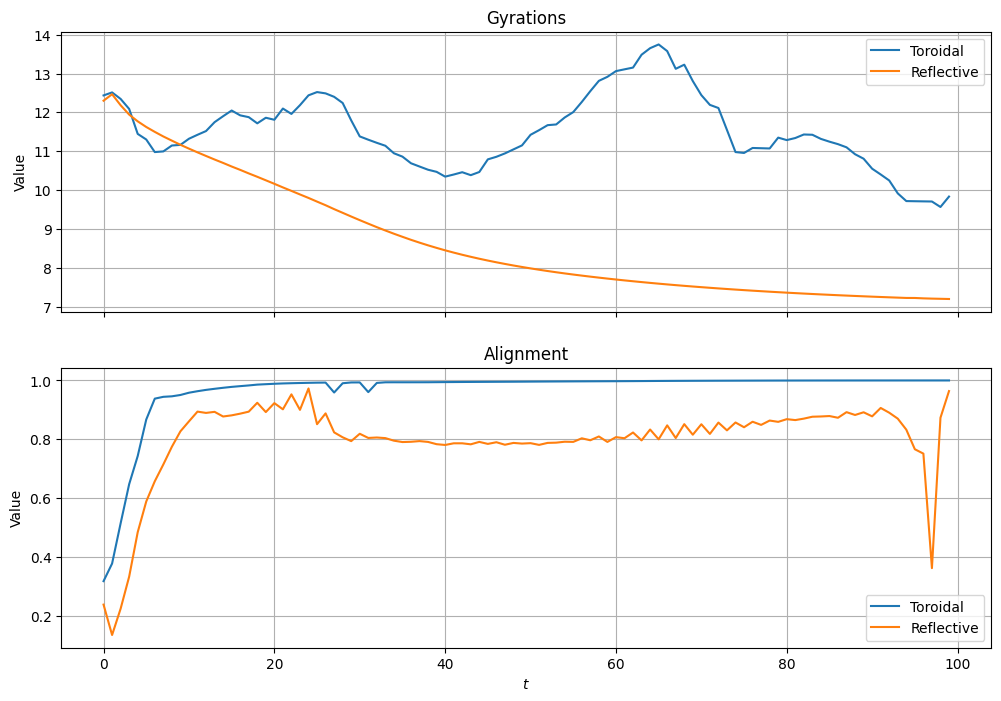

In [26]:
task3()

## Task 4

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from typing import Literal

class VicsekRules(BaseModel):
    r: float
    eta: float #noise amplitude

class Vicsek:
    """Vicsek model of self-propelled particles."""
    def __init__(
        self,
        population_size: int,
        board_width: int,
        board_height: int,
        v: float,
        boundary: Literal["toroidal", "reflective"] = "toroidal",
        seed: int | None = None,
        debug: bool = False,
    ) -> None:
        self._seed = seed
        self._population_size = population_size
        self.height = board_height
        self.width = board_width
        self.v = v
        self._init_particles()
        self._boundary = boundary

        self._rules: Rules | None = None
        self._debug = debug

    def _init_particles(self):
        self.rng = np.random.default_rng(self._seed)
        self.position = self.rng.random((self._population_size, 2), dtype=np.float32) * np.array([self.width, self.height])
        self.angles = self.rng.random(size=self._population_size) * 2 * np.pi
        self.velocity = np.column_stack((np.cos(self.angles), np.sin(self.angles))) * self.v
    
    def set_rules(self, rules: VicsekRules) -> None:
        self._rules = rules

    def step(self, dt: float):
        self.angles = self._get_new_angles()
        self.velocity[:,0] = np.cos(self.angles) * self.v
        self.velocity[:,1] = np.sin(self.angles) * self.v

        if self._boundary == "toroidal":
            self._move_toroidal(dt)
        else:
            self._move_reflective(dt)
        
    def _get_new_angles(self):
        new_angles = np.zeros(self._population_size, dtype=np.float32)
        current_angles = np.arctan2(self.velocity[:,1], self.velocity[:,0])
        for idx, p_i in enumerate(self.position):
            diff = self._get_difference(p_i)
            dists = np.linalg.norm(diff, axis=1)
            
            neighbors = (dists > 0) & (dists < self._rules.r)
            if np.any(neighbors):
                thetas = np.arctan2(self.velocity[neighbors,1],
                                    self.velocity[neighbors,0])
                avg_angle = np.arctan2(np.mean(np.sin(thetas)),
                                    np.mean(np.cos(thetas)))
            else:
                avg_angle = current_angles[idx]
            new_angles[idx] = avg_angle + self._rules.eta * (self.rng.random() - 0.5)
        return new_angles

    def _move_toroidal(self, dt: float):
        self.position = (self.position + self.velocity * dt) % np.array([self.width, self.height])
    
    def _move_reflective(self, dt: float):
        self.position = (self.position + self.velocity * dt)
        out_xbounds = (self.position[:, 0] > self.width) | (self.position[:, 0] < 0)
        self.velocity[out_xbounds, 0] *= -1
        self.position[:, 0] = np.clip(self.position[:, 0], 0, self.width)

        out_ybounds = (self.position[:, 1] > self.height) | (self.position[:, 1] < 0)
        self.velocity[out_ybounds, 1] *= -1
        self.position[:, 1] = np.clip(self.position[:, 1], 0, self.width)

    def _get_difference(self, p_i) -> np.ndarray:
        diff = self.position - p_i
        if self._boundary == "toroidal":
            diff[:, 0] = (diff[:, 0] + self.width / 2) % self.width - self.width / 2
            diff[:, 1] = (diff[:, 1] + self.height / 2) % self.height - self.height / 2
        return diff
    
    def run_simulation(self, T: int, dt: float) -> None:
        steps = int(np.ceil(T / dt))
        for _ in range(steps):
            self.step(dt)

    def animate(self, dt: float, steps=200, interval=50):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])
        quiv = ax.quiver(self.position[:,0], self.position[:,1], self.velocity[:,0], self.velocity[:,1])

        def update(frame):
            self.step(dt)
            quiv.set_offsets(self.position)
            quiv.set_UVC(self.velocity[:,0], self.velocity[:,1])
            return quiv,

        anim = FuncAnimation(fig, update, frames=steps, interval=interval, blit=False)
        outdir = "vicsek_output"
        os.makedirs(outdir, exist_ok=True)

        mp4_path = os.path.join(outdir, "boids.mp4")
        anim.save(mp4_path, fps=30, dpi=80)
        print("Saved MP4:", mp4_path)

        plt.close(fig)


In [27]:
vicsek = Vicsek(
    population_size=60,
    board_width=30,
    board_height=30,
    v=0.1,
    seed=44,
    boundary="toroidal"
)
vrules = VicsekRules(r=5.0, eta=0.1)
vicsek.set_rules(vrules)
vicsek.animate(1.0)

Saved MP4: vicsek_output/boids.mp4


In [87]:
class Vicsek_v2(Vicsek):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.orders: np.ndarray | None = None

    def get_order(self):
        return np.abs(np.mean(np.exp(1j*self.angles)))

    def run_simulation(self, T: int, dt: float) -> None:
        self.orders = np.zeros(int(T/dt), dtype=np.float32)
        steps = int(np.ceil(T / dt))
        for idx in range(steps):
            self.step(dt)
            self.orders[idx] = self.get_order()

In [145]:
def task4(amplitudes):
    T, dt = 10, 0.1
    mcs = 100
    steps = int(T / dt)
    orders = np.zeros((len(amplitudes), steps), dtype=np.float32)
    for idx, eta in tqdm(enumerate(amplitudes), total=len(amplitudes)):
        orders_to_avg = np.zeros((mcs, steps), dtype=np.float32)
        for i in range(mcs):
            vicsek = Vicsek_v2(
                population_size=60,
                board_width=30,
                board_height=30,
                v=0.1,
                boundary="toroidal"
            )
            vrules = VicsekRules(r=4.0, eta=eta)
            vicsek.set_rules(vrules)
            vicsek.run_simulation(T, dt)
            orders_to_avg[i,:] = vicsek.orders
        orders[idx, :] = orders_to_avg.mean(axis=0)
    stationary_order = orders.mean(axis=1)
    return orders, stationary_order

In [146]:
amplitudes = np.linspace(0, 1, 100)
orders, stationary_order = task4(amplitudes)

100%|██████████| 100/100 [20:37<00:00, 12.37s/it]


In [147]:
stationary_order

array([0.531214  , 0.53009915, 0.5413047 , 0.52105194, 0.5454132 ,
       0.5046897 , 0.52772623, 0.53334886, 0.5502276 , 0.54072565,
       0.4934451 , 0.5230328 , 0.5205155 , 0.54066664, 0.55051756,
       0.5472467 , 0.52865785, 0.531916  , 0.55062306, 0.51650786,
       0.5314491 , 0.5402838 , 0.58028054, 0.49818486, 0.52069277,
       0.5344406 , 0.54273415, 0.52929246, 0.53131425, 0.5481451 ,
       0.48504528, 0.52110803, 0.5495346 , 0.5172813 , 0.49378124,
       0.5151165 , 0.53153723, 0.51056254, 0.5102513 , 0.55970186,
       0.5346034 , 0.5103719 , 0.53166276, 0.5136556 , 0.5036134 ,
       0.5154109 , 0.49950847, 0.5096086 , 0.53097594, 0.51609683,
       0.51066095, 0.5400682 , 0.51493144, 0.5217464 , 0.529391  ,
       0.5253825 , 0.5181977 , 0.50293666, 0.542068  , 0.54398155,
       0.49844226, 0.49349815, 0.5150561 , 0.5526567 , 0.47927567,
       0.53344744, 0.5311478 , 0.49643242, 0.4862954 , 0.4912893 ,
       0.4958071 , 0.50992966, 0.506789  , 0.5319551 , 0.46944

In [148]:
def estimate_eta_c(amplitudes, stationary_order, threshold=0.5):
    idx = np.where(stationary_order < threshold)[0][0]
    print(stationary_order[idx])
    print(idx)
    x0, x1 = amplitudes[idx-1], amplitudes[idx]
    y0, y1 = stationary_order[idx-1], stationary_order[idx]
    return x0 + (threshold - y0) * (x1 - x0) / (y1 - y0)

eta_c = estimate_eta_c(amplitudes, stationary_order)
print("Critical noise ηc ≈", eta_c)

0.4934451
10
Critical noise ηc ≈ 0.09960971274754311


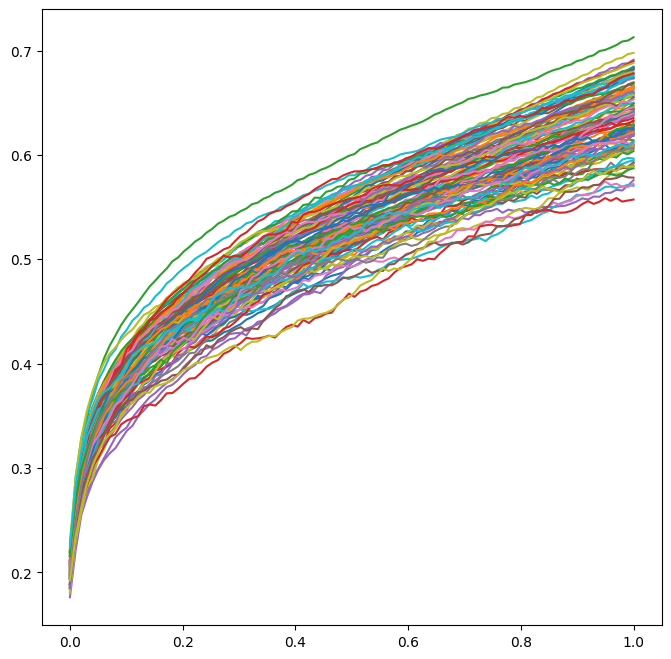

In [149]:
fig, current_ax = plt.subplots(1, 1, figsize=(8,8))
for idx in range(len(orders)):
    current_ax.plot(np.linspace(0, 1, 100), orders[idx,:])

Text(0, 0.5, '$t$')

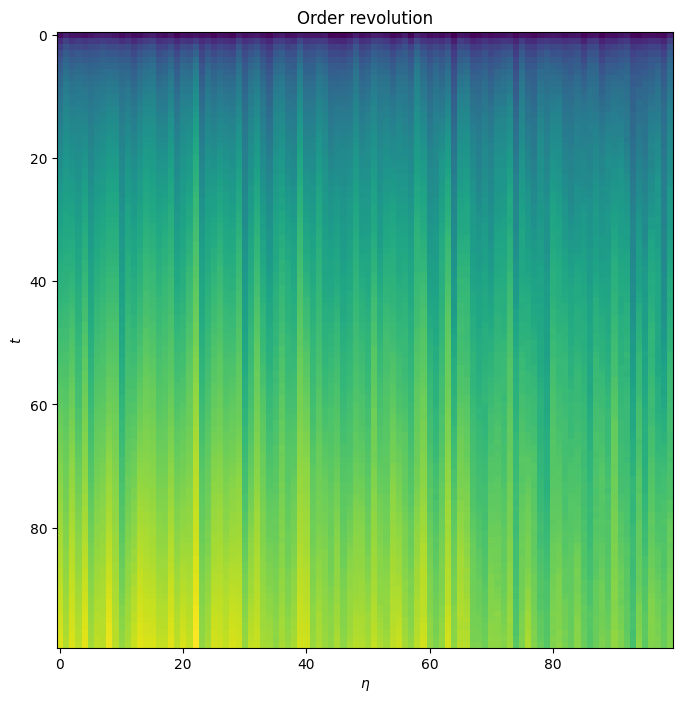

In [150]:
fig, current_ax = plt.subplots(1, 1, figsize=(8,8))
current_ax.imshow(orders.T, cmap='viridis')
current_ax.set_title("Order revolution")
current_ax.set_xlabel("$\\eta$")
current_ax.set_ylabel("$t$")

## Task 5

Angular momentum about the center of mass
$$
L=\frac{1}{N}\sum^N_{i=1}(\mathbf{r}_i-\mathbf{r}_{CM})\times\mathbf{v}_i
$$

In [170]:
class Vicsek_3(Vicsek_v2):
    def get_polarization(self, ra: float):
        alignment_list = np.zeros(len(self.position), dtype=np.float32)
        for idx, (p_i, v_i) in enumerate(zip(self.position, self.velocity)):
            diff = self._get_difference(p_i)
            dists = np.linalg.norm(diff, axis=1)
            neighbors = (dists > 0) & (dists < ra)
            alignment_list[idx] = self._get_alignment(v_i, neighbors)
        return alignment_list.mean()

    def _get_alignment(self, v_i: np.ndarray, neighbors: np.ndarray) -> np.float32:
        if np.any(neighbors):
            avg_vel = self.velocity[neighbors].mean(axis=0)
            steer_align = avg_vel - v_i
        else:
            steer_align = np.zeros(2)
        return np.linalg.norm(steer_align)

    def get_angular_momentum(self):
        r_cm = self.position.mean(axis=0)
        rel_pos = self.position - r_cm
        return np.mean(rel_pos[:,0]*self.velocity[:,1] - rel_pos[:,1]*self.velocity[:,0])

    def get_cluster_count(self, rc: float):
        dist_matrix = squareform(pdist(self.position))
        adjacency = (dist_matrix < rc).astype(int)
        np.fill_diagonal(adjacency, 0)  # remove self-loops
        n_clusters, labels = connected_components(adjacency, directed=False)
        return n_clusters

In [185]:
def task5():
    vicsek = Vicsek_3(
        population_size=60,
        board_width=30,
        board_height=30,
        v=0.1,
        boundary="toroidal"
    )
    mcs = 100
    for rules_config in  [{"r":5.0, "eta":0.1}, {"r":5.0, "eta":0.9}]:
        polarization = np.zeros(mcs, dtype=np.float32)
        am = np.zeros(mcs, dtype=np.float32)
        cc = np.zeros(mcs, dtype=np.float32)
        for idx in tqdm(range(mcs)):
            rules = VicsekRules(**rules_config)
            vicsek.set_rules(rules)
            vicsek.run_simulation(T=10, dt=0.1)

            polarization[idx] = vicsek.get_polarization(ra=rules.r)
            am[idx] = vicsek.get_angular_momentum()
            cc[idx] = vicsek.get_cluster_count(rc=rules.r)
        print("Polarization:", polarization.mean())
        print("Angular momentum:", am.mean())
        print("Cluster count:", cc.mean())

In [187]:
task5()

100%|██████████| 100/100 [00:13<00:00,  7.50it/s]


Polarization: 0.002839961
Angular momentum: -0.005085609
Cluster count: 3.13


100%|██████████| 100/100 [00:13<00:00,  7.50it/s]

Polarization: 0.025530174
Angular momentum: -0.005912667
Cluster count: 2.54
